In [1]:
import numpy as np
from sklearn.datasets import make_regression
X, y = make_regression(n_samples=1000, n_features=4, noise=30, random_state=42)
X = np.hstack((np.ones((X.shape[0],  1)), X))
y=y.reshape(-1,1)
print(X.shape)
print(y.shape)

(1000, 5)
(1000, 1)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
class LinearRegressionOptimizer:
    
    def __init__(self, lr=0.01, method='mbgd', batch_size=None, max_epochs=1000):
        self.lr = lr
        self.method = method
        self.max_epochs = max_epochs
        if method == 'mbgd' and (batch_size is None or batch_size == 0):
            raise ValueError("For Mini-batch Gradient Descent, you must specify the batch size and it should be at least two.")
        self.batch_size = batch_size
        self.theta = None
        self.loss = []
        self.parameters = []
        self.hx = None
        self.gradient_norm = None

    def fit(self, X, y):
        self.theta = np.zeros((X.shape[1], 1))  # Initialize theta
        
        for epoch in range(self.max_epochs):
            X_shuffled, y_shuffled = self.shuffle_data(X, y)
            self.optimize(X_shuffled, y_shuffled)
            j = self.compute_loss(X_shuffled, y_shuffled)  # Compute loss and capture it
            self.loss.append(j)  
            self.record_parameters()
            if self.is_converged():
                break
        self.predict(X)
        self.plot_losses_vs_iterations()
        self.plot_losses_vs_parameters()

    def shuffle_data(self, X, y):
        indices = np.random.permutation(len(X))
        return X[indices], y[indices]

    def optimize(self, X, y):
        if self.method == 'gd':
            self.gradient_descent(X, y)
        elif self.method == 'sgd':
            self.stochastic_gradient_descent(X, y)
        elif self.method == 'mbgd':
            self.mini_batch_gradient_descent(X, y)
        elif self.method == 'momentum':
            if self.batch_size is None:
                self.momentum_gradient_descent(X, y)
            elif self.batch_size == 1:
                self.momentum_stochastic_gradient_descent(X, y)
            else:
                self.momentum_mini_batch_gradient_descent(X, y)

    def compute_loss(self, X, y):
        hx = np.dot(X, self.theta)
        error = hx - y
        j = np.sum(error ** 2) / (2 * len(X))
        return j  # Return the computed loss

    def is_converged(self):
        if len(self.loss) > 1 and abs(self.loss[-1] - self.loss[-2]) < 1e-3 or self.gradient_norm < 1e-3:
            return True
        return False

    def predict(self, X):
        self.hx = np.dot(X, self.theta)

    def record_parameters(self):
        self.parameters.append(self.theta.flatten())

    def gradient_descent(self, X, y):
        hx = np.dot(X, self.theta)
        error = hx - y
        gradient = np.dot(X.T, error) / len(X)
        self.theta -= self.lr * gradient
        self.gradient_norm = np.linalg.norm(self.theta)

    def stochastic_gradient_descent(self, X, y):
        for i in range(len(X)):
            hx = np.dot(X[i], self.theta)
            error = hx - y[i]
            gradient = X[i].reshape(-1, 1) * error
            self.theta -= self.lr * gradient
            self.gradient_norm = np.linalg.norm(self.theta)

    def mini_batch_gradient_descent(self, X, y):
        num_batches = int(np.ceil(len(X) / self.batch_size))
        for i in range(num_batches):
            start_idx = i * self.batch_size
            end_idx = (i + 1) * self.batch_size
            X_batch, y_batch = X[start_idx:end_idx], y[start_idx:end_idx]
            hx = np.dot(X_batch, self.theta)
            error = hx - y_batch
            gradient = np.dot(X_batch.T, error) / len(X_batch)
            self.theta -= self.lr * gradient
            self.gradient_norm = np.linalg.norm(self.theta)
            
    def momentum_gradient_descent(self, X, y):
        self.v = np.zeros_like(self.theta)
        gamma = 0.9
        gradient = np.dot(X.T, (np.dot(X, self.theta) - y)) / len(X)
        self.v = gamma * self.v + self.lr * gradient
        self.theta -= self.v
        self.gradient_norm = np.linalg.norm(self.theta)

    def momentum_stochastic_gradient_descent(self, X, y):
        self.v = np.zeros_like(self.theta)
        gamma = 0.9
        for i in range(len(X)):
            gradient = X[i].reshape(-1, 1) * (np.dot(X[i], self.theta) - y[i])
            self.v = gamma * self.v + self.lr * gradient
            self.theta -= self.v
            self.gradient_norm = np.linalg.norm(self.theta)

    def momentum_mini_batch_gradient_descent(self, X, y):
        self.v = np.zeros_like(self.theta)
        gamma = 0.9
        num_batches = int(np.ceil(len(X) / self.batch_size))
        for i in range(num_batches):
            start_idx = i * self.batch_size
            end_idx = (i + 1) * self.batch_size
            X_batch, y_batch = X[start_idx:end_idx], y[start_idx:end_idx]
            gradient = np.dot(X_batch.T, (np.dot(X_batch, self.theta) - y_batch)) / len(X_batch)
            self.v = gamma * self.v + self.lr * gradient
            self.theta -= self.v
            self.gradient_norm = np.linalg.norm(self.theta)
            
    def plot_losses_vs_iterations(self):
        plt.plot(self.loss, color="r")
        plt.title('Losses vs. Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.show()

    def plot_losses_vs_parameters(self):
        parameters = np.array(self.parameters)
        num_params = parameters.shape[1]
        num_plots = num_params // 2 + num_params % 2
        
        fig, axes = plt.subplots(num_plots, 2, figsize=(10, 5*num_plots))
        for i in range(num_plots):
            for j in range(2):
                if i * 2 + j < num_params:
                    axes[i, j].plot(parameters[:, i * 2 + j], self.loss, marker='o', color="purple")
                    axes[i, j].set_title(f'Losses vs. Parameter {i * 2 + j + 1}')
                    axes[i, j].set_xlabel(f'Parameter {i * 2 + j + 1}')
                    axes[i, j].set_ylabel('Loss')
        plt.tight_layout()
        plt.show()

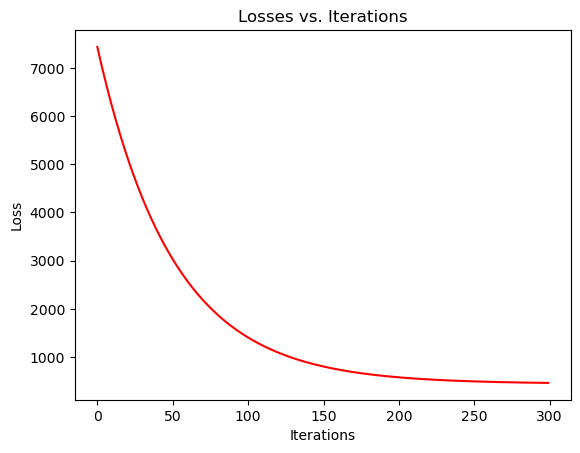

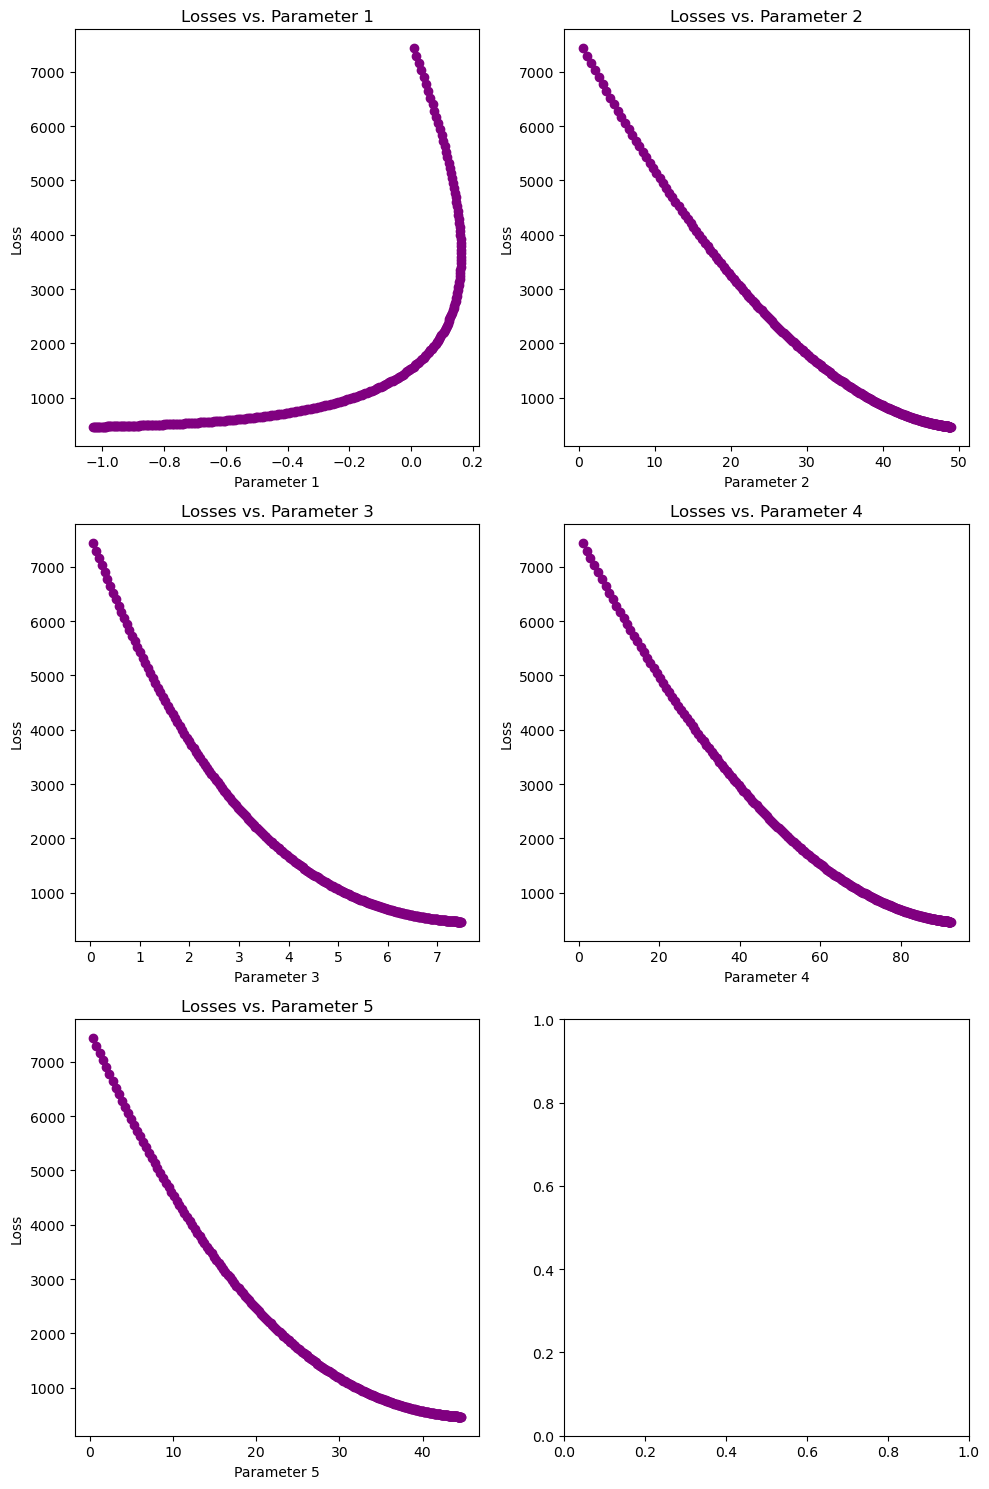

Optimized Parameters: 
 [[-1.02998384]
 [48.87009303]
 [ 7.47520537]
 [92.44108844]
 [44.60240429]]
Final Loss: 463.3494364083872
Final R-squared value: 93.88%


In [3]:
# Example usage
lr_optimizer = LinearRegressionOptimizer(method='momentum', batch_size=None ,lr=0.01, max_epochs=300)
lr_optimizer.fit(X, y)
print("Optimized Parameters: \n", lr_optimizer.theta)
print("Final Loss:", lr_optimizer.loss[-1])

# Compute R-squared
r_squared = r2_score(y, lr_optimizer.hx)
print("Final R-squared value: {:.2f}%".format(r_squared * 100))

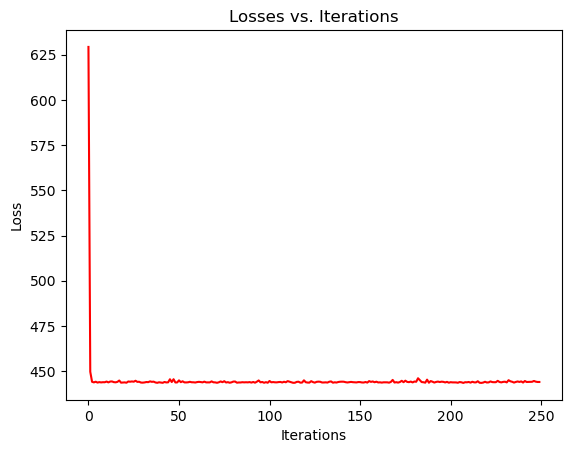

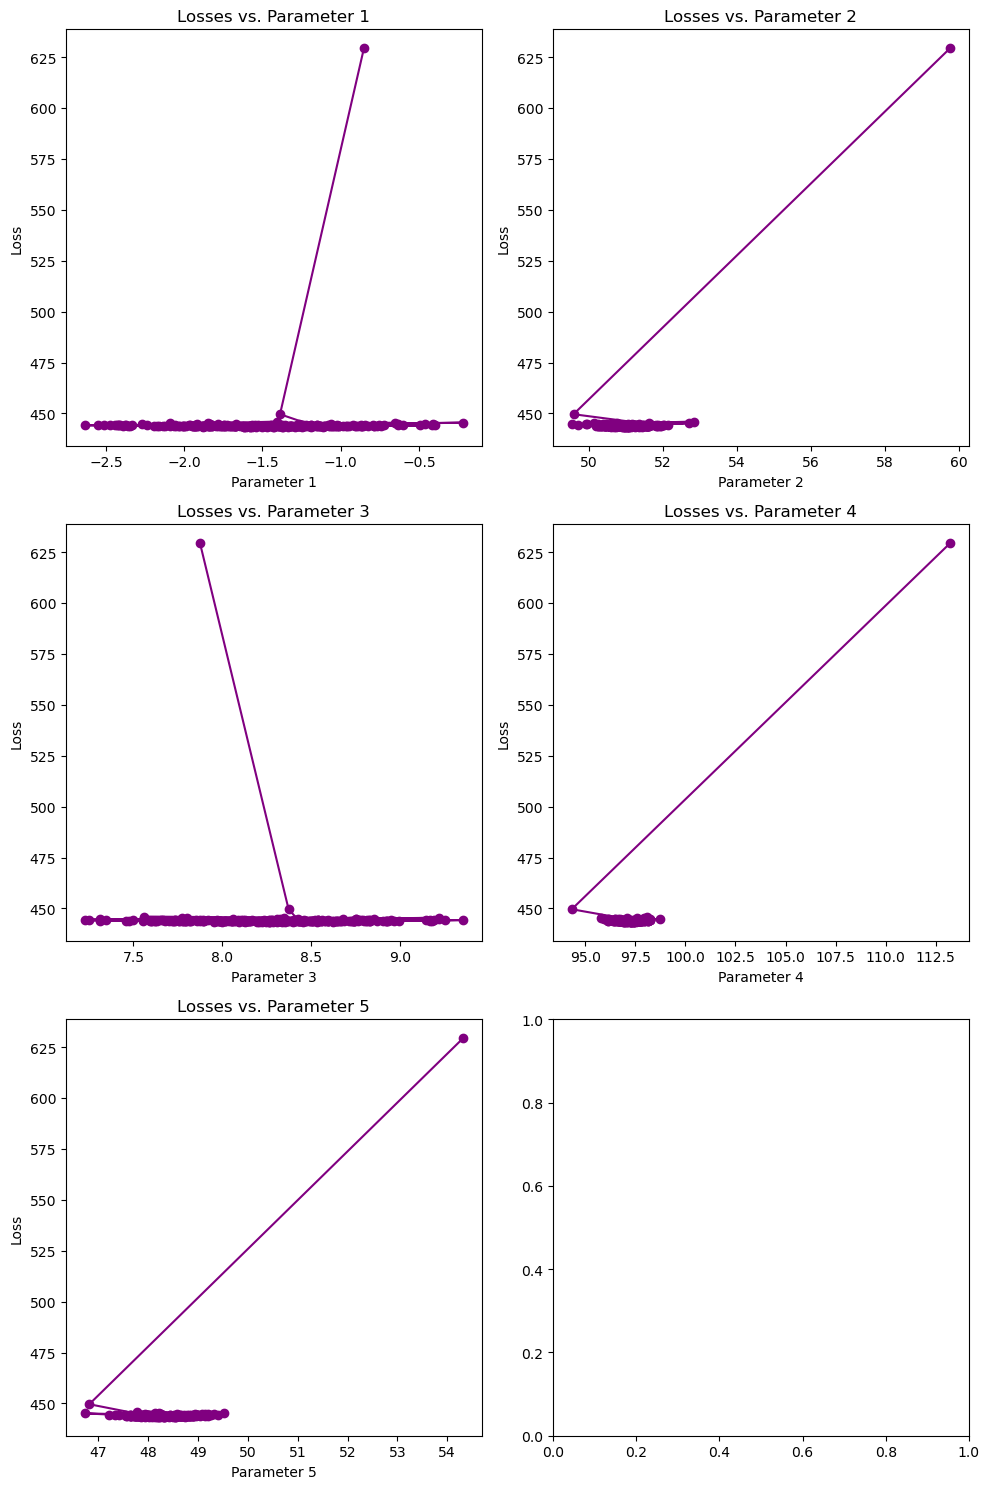

Optimized Parameters: 
 [[-0.82712237]
 [50.72763291]
 [ 7.70067141]
 [97.14960417]
 [47.76237827]]
Final Loss: 443.97368371852093
Final R-squared value: 94.14%


In [4]:
# Example usage
lr_optimizer = LinearRegressionOptimizer(method='momentum', batch_size=32 ,lr=0.01, max_epochs=300)
lr_optimizer.fit(X, y)
print("Optimized Parameters: \n", lr_optimizer.theta)
print("Final Loss:", lr_optimizer.loss[-1])

# Compute R-squared
r_squared = r2_score(y, lr_optimizer.hx)
print("Final R-squared value: {:.2f}%".format(r_squared * 100))

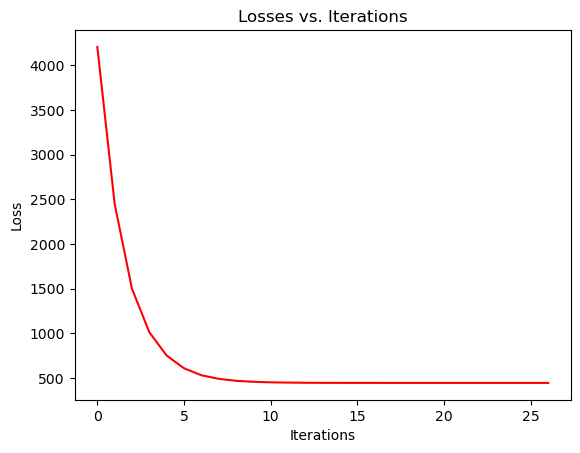

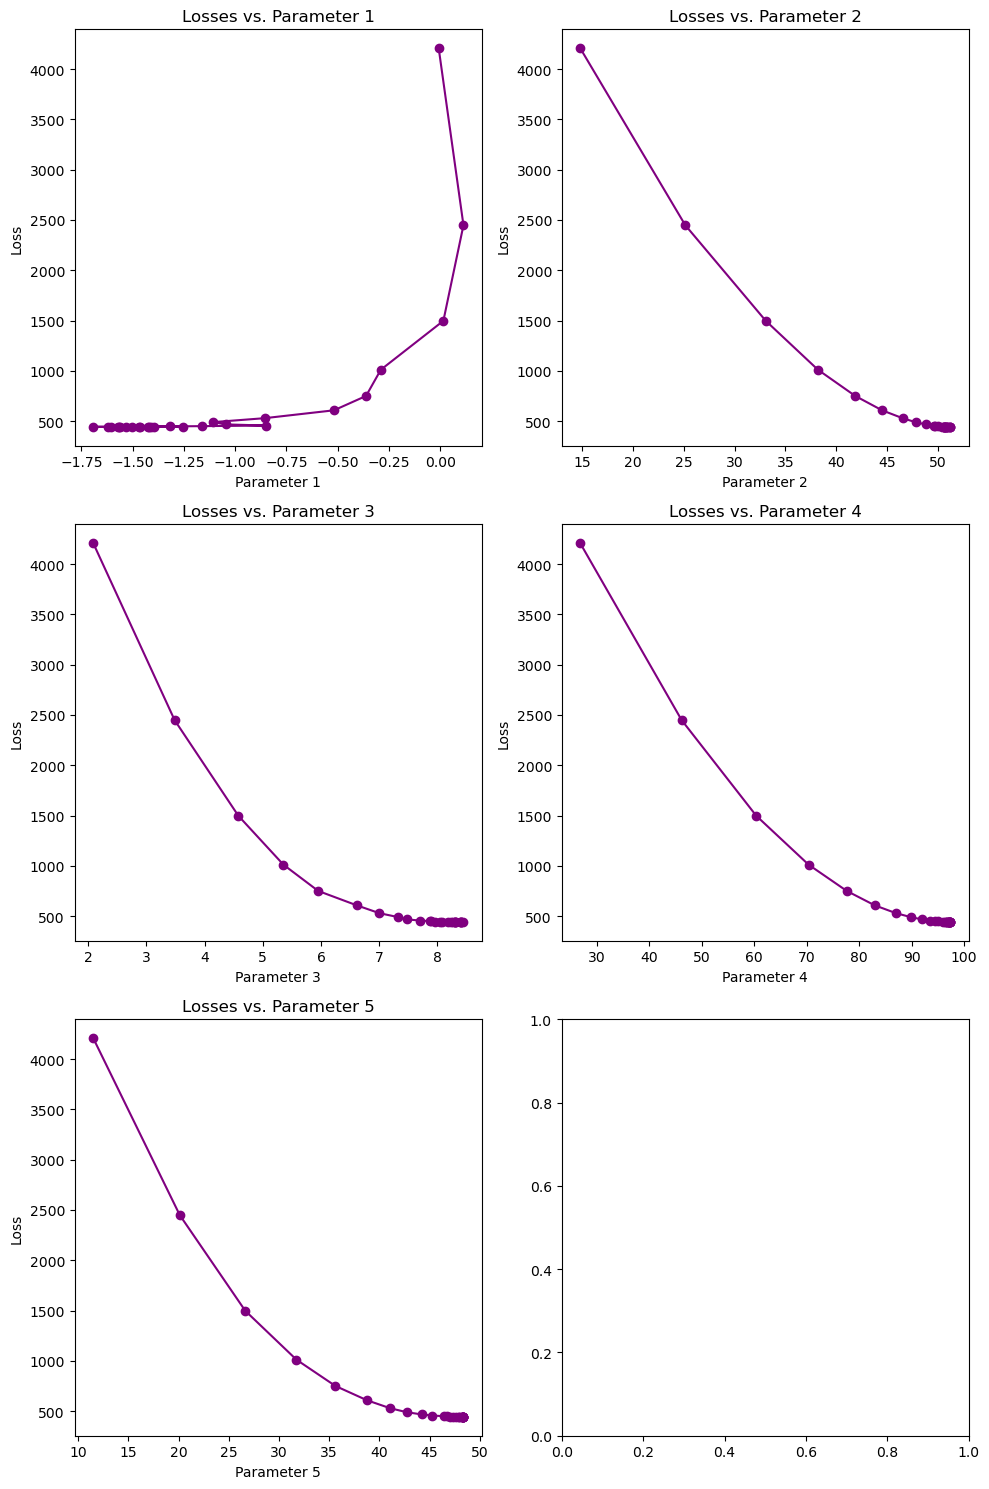

Optimized Parameters: 
 [[-1.56033795]
 [51.15760738]
 [ 8.39714516]
 [97.383895  ]
 [48.3065002 ]]
Final Loss: 443.4937377539207
Final R-squared value: 94.15%


In [5]:
lr_optimizer = LinearRegressionOptimizer(method='mbgd', batch_size=32 ,lr=0.01, max_epochs=300)
lr_optimizer.fit(X, y)
print("Optimized Parameters: \n", lr_optimizer.theta)
print("Final Loss:", lr_optimizer.loss[-1])

# Compute R-squared
r_squared = r2_score(y, lr_optimizer.hx)
print("Final R-squared value: {:.2f}%".format(r_squared * 100))

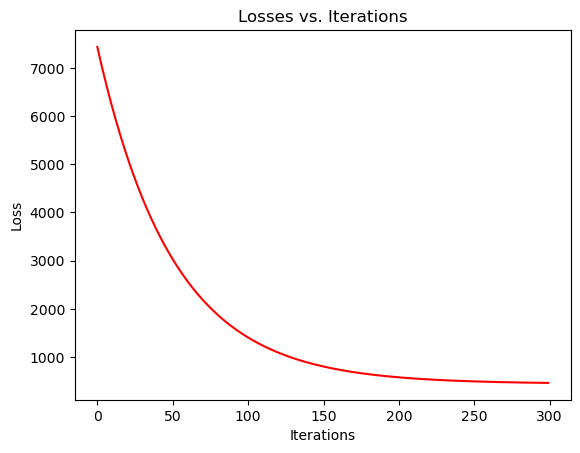

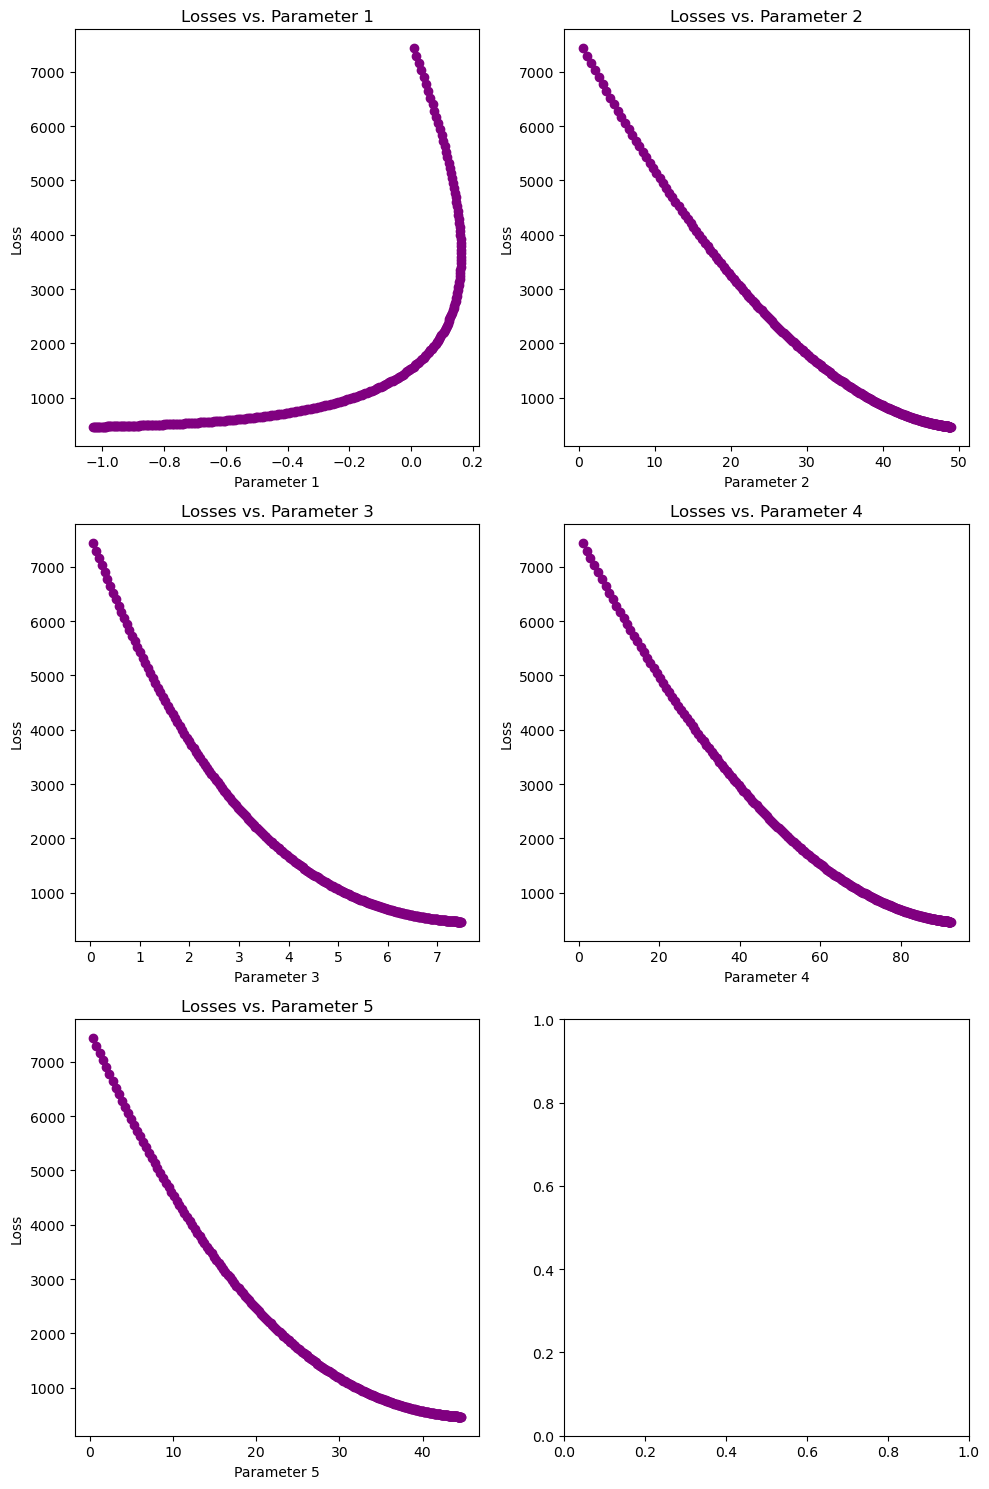

Optimized Parameters: 
 [[-1.02998384]
 [48.87009303]
 [ 7.47520537]
 [92.44108844]
 [44.60240429]]
Final Loss: 463.3494364083872
Final R-squared value: 93.88%


In [6]:
lr_optimizer = LinearRegressionOptimizer(method='mbgd', batch_size=len(X) ,lr=0.01, max_epochs=300)
lr_optimizer.fit(X, y)
print("Optimized Parameters: \n", lr_optimizer.theta)
print("Final Loss:", lr_optimizer.loss[-1])

# Compute R-squared
r_squared = r2_score(y, lr_optimizer.hx)
print("Final R-squared value: {:.2f}%".format(r_squared * 100))

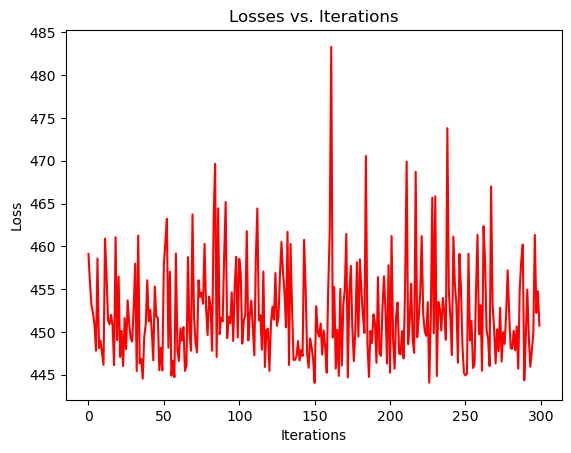

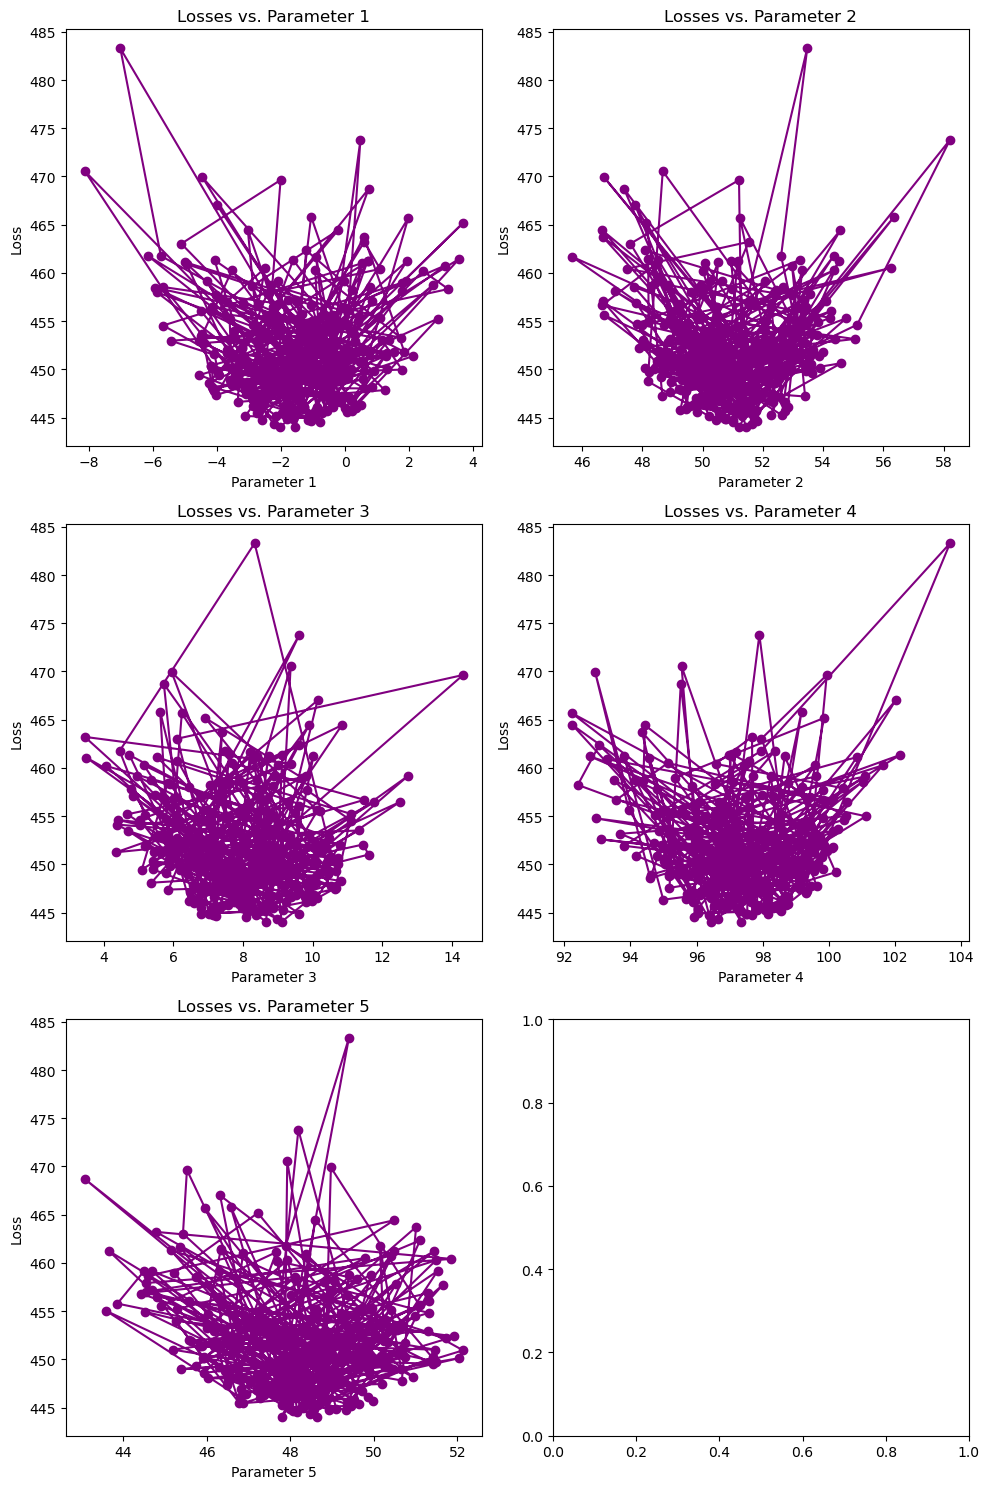

Optimized Parameters: 
 [[ 0.47203785]
 [51.60255738]
 [ 6.86412971]
 [99.7862415 ]
 [49.62190074]]
Final Loss: 450.73700545100553
Final R-squared value: 94.05%


In [7]:
lr_optimizer = LinearRegressionOptimizer(method='mbgd', batch_size=1 ,lr=0.01, max_epochs=300)
lr_optimizer.fit(X, y)
print("Optimized Parameters: \n", lr_optimizer.theta)
print("Final Loss:", lr_optimizer.loss[-1])

# Compute R-squared
r_squared = r2_score(y, lr_optimizer.hx)
print("Final R-squared value: {:.2f}%".format(r_squared * 100))

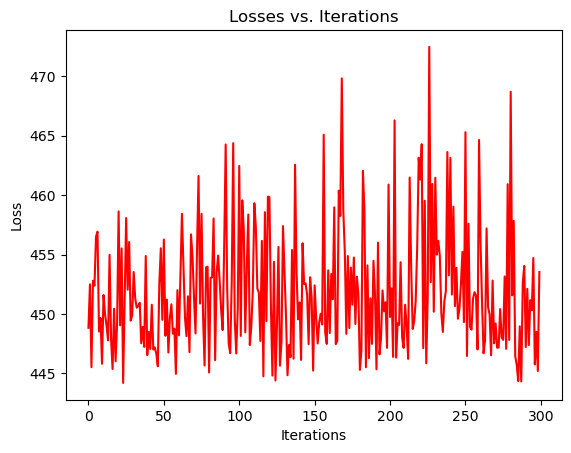

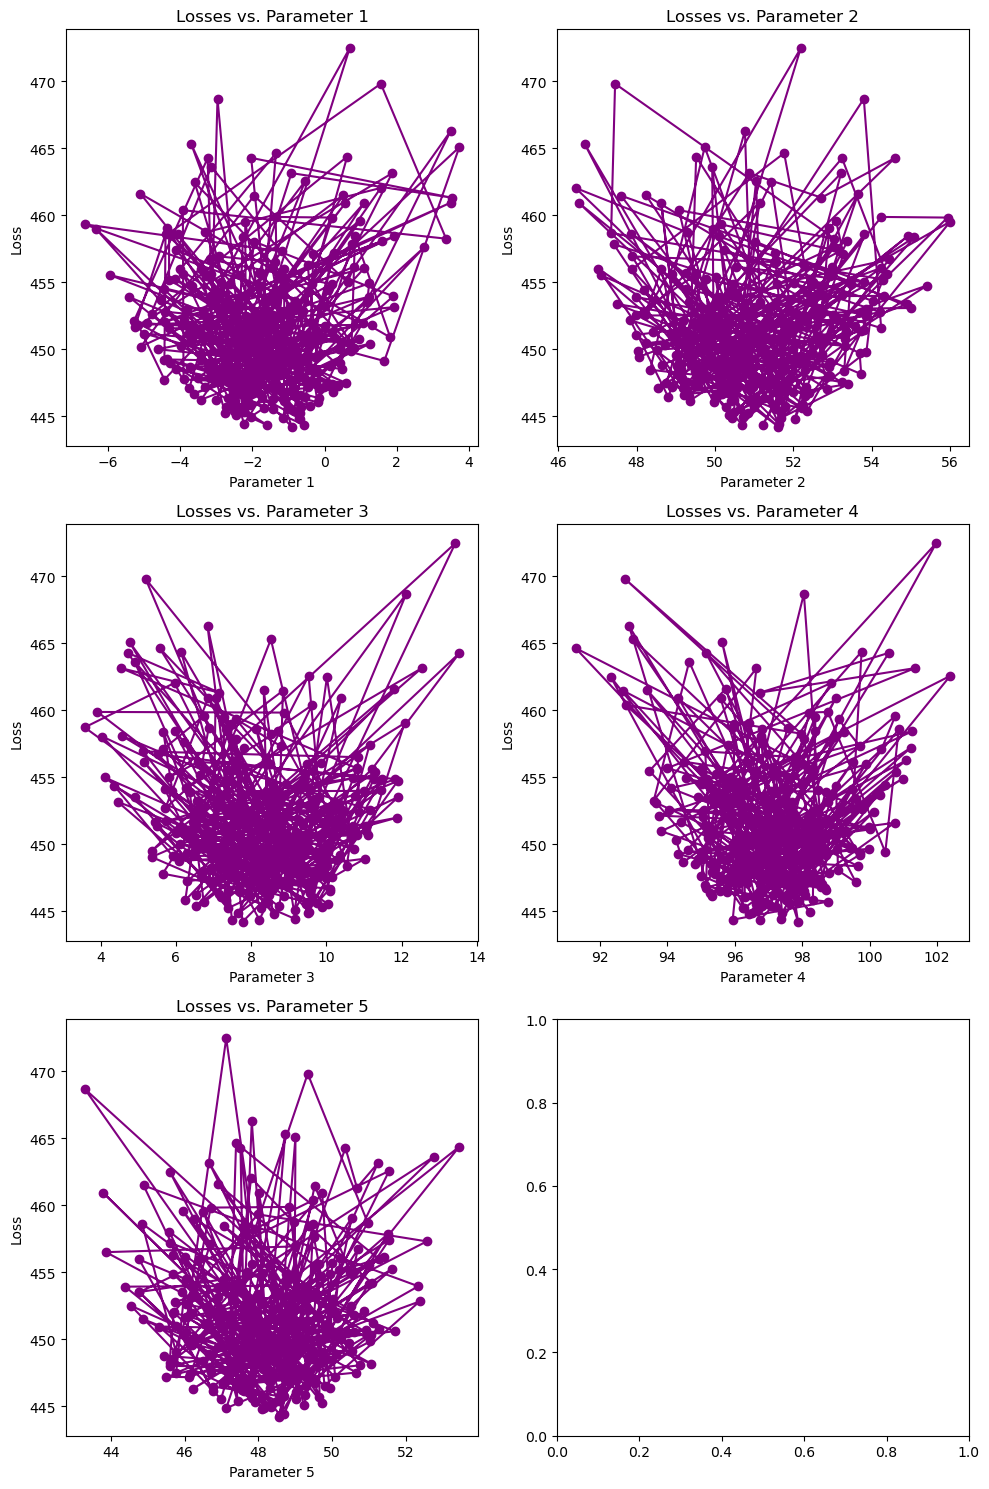

Optimized Parameters: 
 [[-1.40652724]
 [49.32891256]
 [ 4.90834632]
 [96.14123124]
 [45.92085918]]
Final Loss: 453.53261236503766
Final R-squared value: 94.01%


In [8]:
lr_optimizer = LinearRegressionOptimizer(method='sgd', batch_size=1 ,lr=0.01, max_epochs=300)
lr_optimizer.fit(X, y)
print("Optimized Parameters: \n", lr_optimizer.theta)
print("Final Loss:", lr_optimizer.loss[-1])

# Compute R-squared
r_squared = r2_score(y, lr_optimizer.hx)
print("Final R-squared value: {:.2f}%".format(r_squared * 100))